In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

# to determine the most voted
import collections

# Aux functions

In [2]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def show_data(s1,l1, s2,l2, labels, min):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom = min)
    plt.legend(loc='upper left')
    plt.show()

def show_batch(image_batch, label_batch):
  columns = 8
  rows = BATCH_SIZE / columns + 1
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')

def show_batch_gray(image_batch, label_batch):
  columns = 8
  rows = BATCH_SIZE / columns + 1
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]),cmap="gray")
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


def show_accuracies(labels, test, val):

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.97)
    plt.legend(loc='upper left')
    plt.show()



def show_misclassified(predictions, ground_truth, images, num_rows = 5, num_cols=3):

    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    print(num_images)
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(43))
    plt.yticks([])
    thisplot = plt.bar(range(43), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.where(true_label)[0][0]].set_color('blue')



def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(8,6))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()

# Callbacks

In [3]:
class EarlyStoppingAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.target_accuracy:
            print(f"\nReached target validation accuracy ({self.target_accuracy}), stopping training!")
            self.model.stop_training = True

def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path,
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    early_stopping = EarlyStoppingAtAccuracy(target_accuracy=1.0)

    return [checkpointer, earlyStopper, reduceLR, early_stopping]


# Batch Size
Batch size is an important parameter when training a network. It can influence speed and generalization, not necessarily in the same direction. There is no golden rule for the batch size but 32 is a commom number to start with.

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 32

# Settings

In [9]:
data_path = 'GTSRB'
log_and_model_path = 'cache/'

# Prepare to load images

In [10]:
classNames = np.array(os.listdir(f'{data_path}/Final_Training/Images'))
classNames

array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

# Convert Images to png (only performed once)

In [ ]:

from PIL import Image
import glob
"""
images = glob.glob(f'{data_path}/Final_Training/Images/**/*.ppm',recursive=True)
for image in images:
     im = Image.open(image)
     im.save(f'{image}.png')
"""

In [ ]:
"""
images = glob.glob(f'{data_path}/test/**/*.ppm',recursive=True)
for image in images:
     im = Image.open(image)
     im.save(f'{image}.png')
"""

# Loading images takes place in here

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    f'{data_path}/Final_Training/Images',
    batch_size = None,
    label_mode = 'categorical',
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True)

normalize = tf.keras.layers.Rescaling(1.0/255)
dataset = dataset.map(lambda x, y: (normalize(x), y))

Found 39209 files belonging to 43 classes.


In [12]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    f'{data_path}/test',
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = 128,
    label_mode = 'categorical',
    shuffle = False)

testset = testset.map(lambda x, y: (normalize(x), y))


Found 12630 files belonging to 43 classes.


# Split images to validation and training

In [13]:
nr = dataset.cardinality().numpy()
valset = dataset.take(int(nr * 0.20))
trainset = dataset.skip(int(nr * 0.20))


# Information about image shape and size of training set

In [14]:
t = next(iter(trainset))
print(t[0].shape, t[1].shape)

# note: this only works if dataset is not repeating
dataset_length = trainset.cardinality().numpy()
print("Total images in dataset: ", dataset_length)

(32, 32, 3) (43,)
Total images in dataset:  31368


# Shape Dataset

In [15]:
trainset = trainset.map(lambda image, label: (tf.image.resize(image, [IMAGE_SIZE,IMAGE_SIZE]),label), num_parallel_calls= AUTOTUNE)
valset = valset.map(lambda image, label: (tf.image.resize(image, [IMAGE_SIZE,IMAGE_SIZE]),label), num_parallel_calls= AUTOTUNE)

# Version I - training with dataset only
## Preparing training, validation and test datasets

In [ ]:
dataSolo = trainset
dataSolo = dataSolo.cache()
dataSolo = dataSolo.prefetch(buffer_size=10200)
dataSolo = dataSolo.batch(batch_size=BATCH_SIZE)

In [17]:
valset = valset.cache()
valset = valset.batch(batch_size = 2580)
valset = valset.prefetch(buffer_size = AUTOTUNE)

# Show a batch of training images

2023-06-13 12:02:53.251415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [39209]
	 [[{{node Placeholder/_4}}]]
2023-06-13 12:02:53.251612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [39209]
	 [[{{node Placeholder/_4}}]]
2023-06-13 12:03:00.057539: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pip

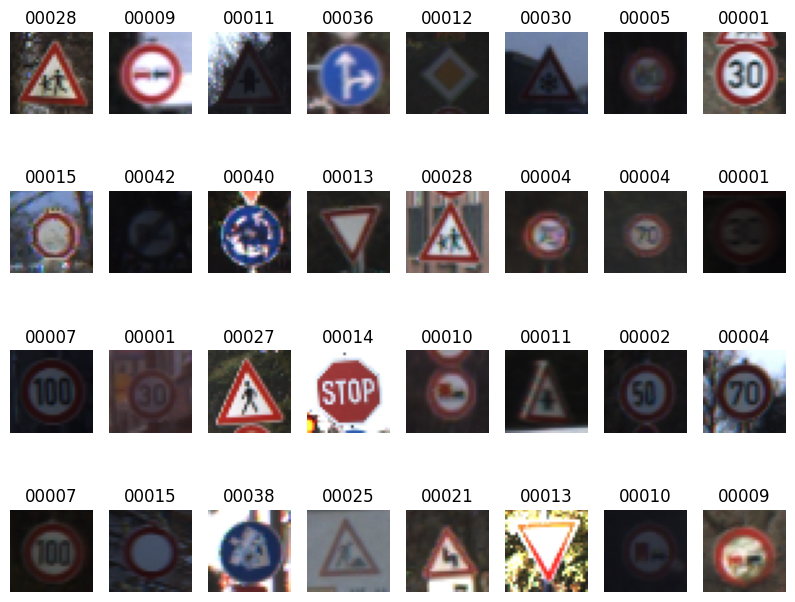

In [ ]:
image_batch, label_batch = next(iter(dataSolo))
show_batch(image_batch, label_batch.numpy())

# Build a CNN network

In [16]:
def model_III(classCount, imgSize, channels):

    model = Sequential()

    model.add(Conv2D(128, (5, 5), input_shape=(imgSize, imgSize, channels)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (5, 5) ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (5, 5) ) )
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))

    model.add(Dense(classCount, activation='softmax'))


    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

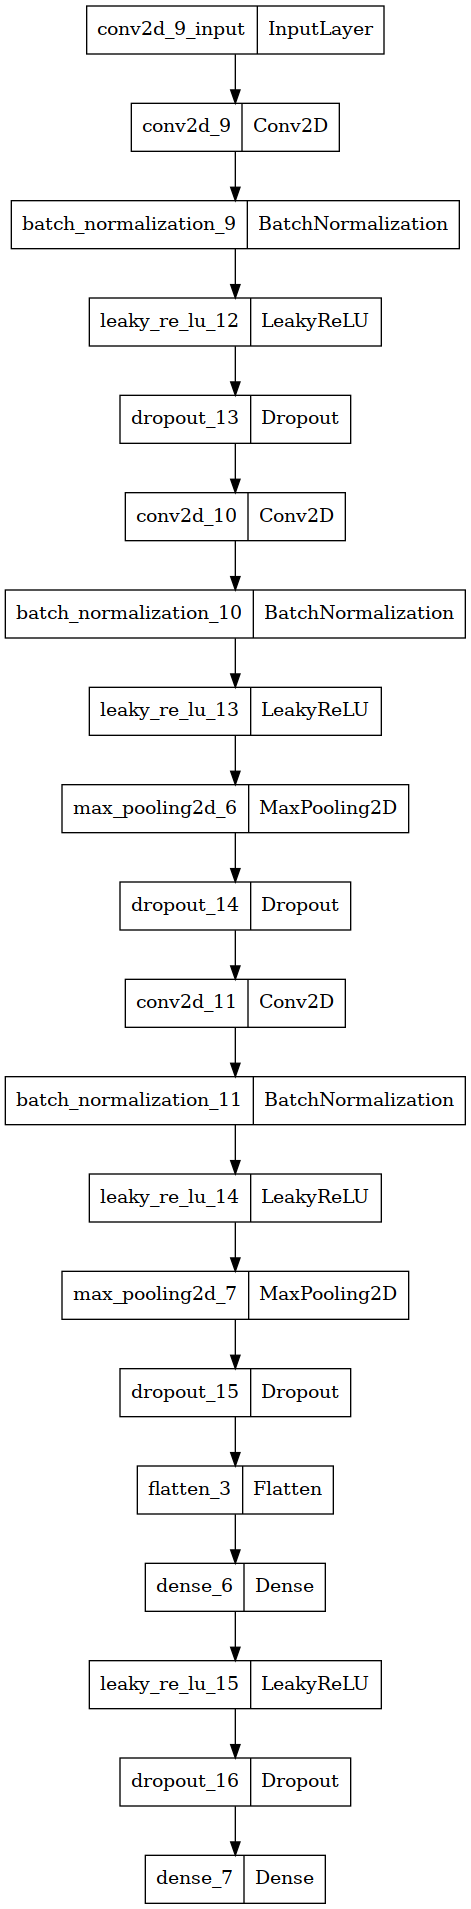

In [ ]:
modelV1 = model_III(43, IMAGE_SIZE, 3)

from tensorflow.keras.utils import plot_model
plot_model(modelV1)

# Train the network

In [ ]:
file_pathV1 = f'{log_and_model_path}/V1/cp.ckpt'

In [ ]:
callbacksV1 = prepare_callbacks(file_pathV1)

historyV1 = modelV1.fit(dataSolo,
          epochs = 50,
          validation_data = valset,
          callbacks = callbacksV1)

979/981 [============================>.] - ETA: 0s - loss: 0.3267 - accuracy: 0.8995
Epoch 2: val_accuracy improved from 0.89032 to 0.96582, saving model to cache//V1/cp.ckpt
981/981 [==============================] - 21s 21ms/step - loss: 0.3266 - accuracy: 0.8995 - val_loss: 0.1277 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 3/50
979/981 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9491
Epoch 3: val_accuracy improved from 0.96582 to 0.96977, saving model to cache//V1/cp.ckpt
981/981 [==============================] - 20s 21ms/step - loss: 0.1690 - accuracy: 0.9491 - val_loss: 0.1271 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 4/50
979/981 [============================>.] - ETA: 0s - loss: 0.1221 - accuracy: 0.9646
Epoch 4: val_accuracy improved from 0.96977 to 0.97717, saving model to cache//V1/cp.ckpt
981/981 [==============================] - 20s 20ms/step - loss: 0.1222 - accuracy: 0.9646 - val_loss: 0.0815 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 5/50
979/

# Evaluate Model

In [ ]:
modelV1.load_weights(file_pathV1)

evalV1 = modelV1.evaluate(testset, verbose=2)

2023-06-13 14:50:53.506709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12630]
	 [[{{node Placeholder/_0}}]]
2023-06-13 14:50:53.506851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12630]
	 [[{{node Placeholder/_4}}]]


99/99 - 9s - loss: 0.1411 - accuracy: 0.9841 - 9s/epoch - 87ms/step


show misscalssified

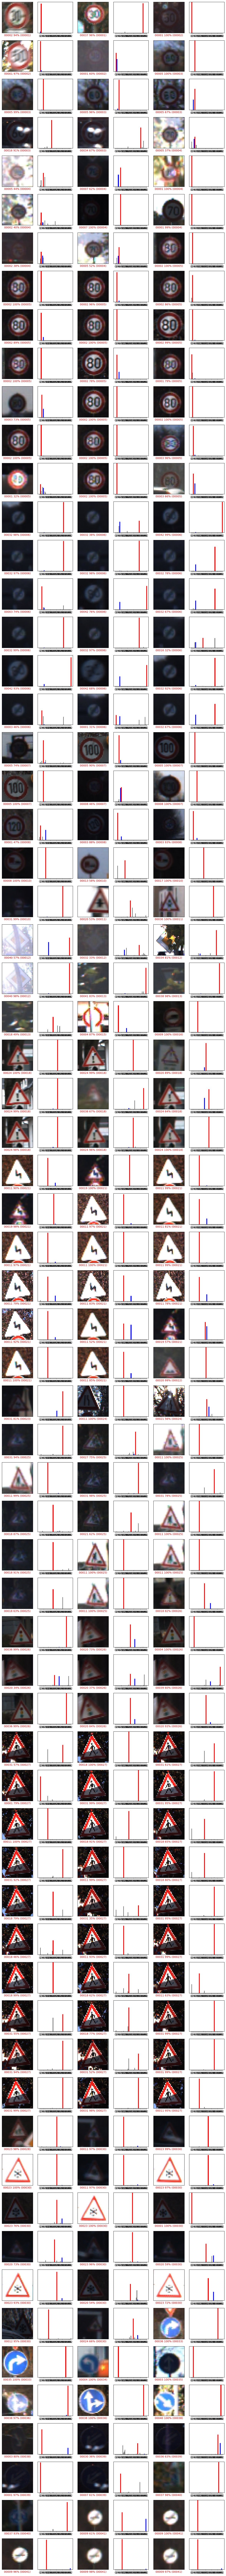

In [ ]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in testset.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV1.predict(images.numpy()))


show_misclassified(pred, numpy_labels, numpy_images, int((12630 - 12630*.9841)/3 + 1))

# Version II - dynamic data augmentation
## Function to transform image

In [ ]:
import tensorflow_addons as tfa


def process_image(image, label):

    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    image = tfa.image.translate(image, [rx, ry])

    # change hue, saturation and value
    image = tfa.image.random_hsv_in_yiq(image, 0.2, 0.1, 3, 0.1, 3)
    image = tf.clip_by_value(image,0,1)

    return image, label

/home/mic/miniconda3/envs/tf/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
dataV2 = dataset
dataset_length = dataset.cardinality().numpy()
dataV2 = dataV2.cache()
dataV2 = dataV2.shuffle(buffer_size = dataset_length)
dataV2 = dataV2.map(process_image)
dataV2 = dataV2.prefetch(buffer_size=10200)
dataV2 = dataV2.batch(batch_size=BATCH_SIZE)

In [ ]:

modelV2 = model_III(43, IMAGE_SIZE, 3)

file_pathV2 = f'{log_and_model_path}/DA_modelV2/cp.ckpt'

In [ ]:
callbacksV2 = prepare_callbacks(file_pathV2)

historyV2 = modelV2.fit(dataV2,
          epochs = 50,
          validation_data = valset,
          callbacks = callbacksV2)

Epoch 1/50


2023-06-12 12:10:31.946146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [39209]
	 [[{{node Placeholder/_4}}]]
2023-06-12 12:10:31.946361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [39209]
	 [[{{node Placeholder/_0}}]]
2023-06-12 12:10:32.404766: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-12 12:10:42.459825: I tensorflow/

1226/1226 [==============================] - ETA: 0s - loss: 2.6631 - accuracy: 0.2585
Epoch 1: val_accuracy improved from -inf to 0.55949, saving model to cache//DA_modelV2/cp.ckpt
1226/1226 [==============================] - 76s 34ms/step - loss: 2.6631 - accuracy: 0.2585 - val_loss: 1.3329 - val_accuracy: 0.5595 - lr: 0.0010
Epoch 2/50
1225/1226 [============================>.] - ETA: 0s - loss: 1.4707 - accuracy: 0.5403
Epoch 2: val_accuracy improved from 0.55949 to 0.81686, saving model to cache//DA_modelV2/cp.ckpt
1226/1226 [==============================] - 41s 33ms/step - loss: 1.4706 - accuracy: 0.5403 - val_loss: 0.5546 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 3/50
1225/1226 [============================>.] - ETA: 0s - loss: 0.8583 - accuracy: 0.7317
Epoch 3: val_accuracy improved from 0.81686 to 0.95358, saving model to cache//DA_modelV2/cp.ckpt
1226/1226 [==============================] - 38s 31ms/step - loss: 0.8582 - accuracy: 0.7318 - val_loss: 0.1678 - val_accuracy: 0.

In [ ]:
modelV2.load_weights(file_pathV2)

evalV2 = modelV2.evaluate(testset, verbose=2)

99/99 - 9s - loss: 0.0592 - accuracy: 0.9894 - 9s/epoch - 89ms/step


## Show missmatched

2023-06-12 12:27:33.216098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12630]
	 [[{{node Placeholder/_0}}]]
2023-06-12 12:27:33.216234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12630]
	 [[{{node Placeholder/_4}}]]


3/3 [==============================] - 0s 189ms/step
162


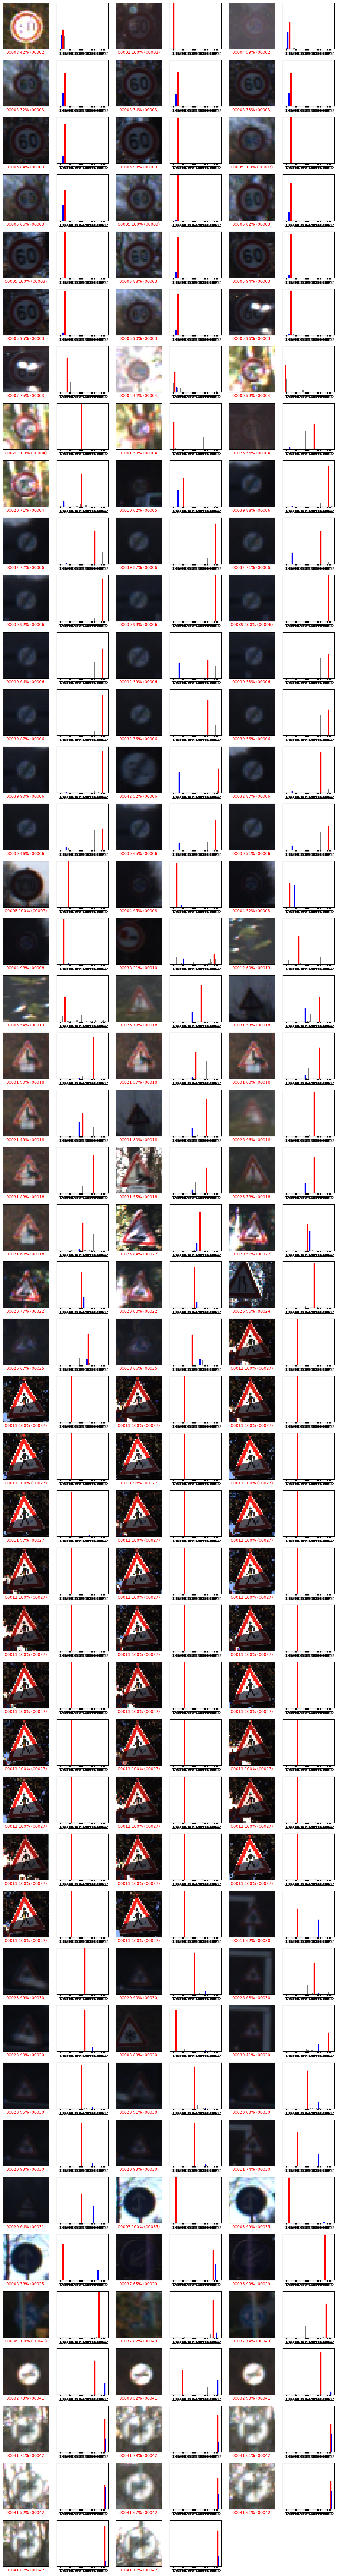

In [ ]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in testset.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV2.predict(images.numpy()))


show_misclassified(pred, numpy_labels, numpy_images, int((12630 - 12630*.9894)/3 + 1))

# Version III - Massive data augmentation
## Data augmentation functions

In [26]:
import tensorflow_addons as tfa

def process_image(image, label):

    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    image = tfa.image.translate(image, [rx, ry])

    # change hue, saturation and value
    image = tfa.image.random_hsv_in_yiq(image, 0.2, 0.1, 3, 0.1, 3)
    image = tf.clip_by_value(image,0,1)

    return image, label

def process_brightness(image, label):

    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):

    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):

    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):

    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):

    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [IMAGE_SIZE,IMAGE_SIZE])
    return img, label

def salt_and_pepper(image,label, prob_salt=0.1, prob_pepper=0.1):#faz riscas
    random_values = tf.random.uniform(shape=image[0, ..., -1:].shape)
    image = tf.where(random_values < prob_salt, 1., image)
    image = tf.where(1 - random_values < prob_pepper, 0., image)
    return image,label

def process_squares(image, label):
    image = tf.expand_dims(image, axis=0)
    size_hor = int(tf.random.uniform(shape=(), minval=0, maxval=16, dtype=tf.dtypes.int32)/2)
    size_hor = tf.cond(tf.math.equal(size_hor % 2, 1),
                        lambda: size_hor + 1,
                        lambda: size_hor)
    size_ver = int(tf.random.uniform(shape=(), minval=0, maxval=16, dtype=tf.dtypes.int32)/2)
    size_ver = tf.cond(tf.math.equal(size_ver % 2, 1),
                        lambda: size_ver + 1,
                        lambda: size_ver)

    val = tf.random.uniform(shape=(), minval=0, maxval=1, dtype=tf.dtypes.float32)
    return tf.squeeze(tfa.image.random_cutout(image, (size_hor, size_ver), constant_values = val), axis=0), label

def process_hlines(image, label):
    image = tf.expand_dims(image, axis=0)
    size_ver = int(tf.random.uniform(shape=(), minval=0, maxval=8, dtype=tf.dtypes.int32)/2)
    size_ver = tf.cond(tf.math.equal(size_ver % 2, 1),
                        lambda: size_ver + 1,
                        lambda: size_ver)

    val = tf.random.uniform(shape=(), minval=0, maxval=1, dtype=tf.dtypes.float32)
    return tf.squeeze(tfa.image.random_cutout(image, (size_ver, IMAGE_SIZE), constant_values = val), axis=0), label

def process_vlines(image, label):
    image = tf.expand_dims(image, axis=0)
    size_hor = int(tf.random.uniform(shape=(), minval=0, maxval=8, dtype=tf.dtypes.int32)/2)
    size_hor = tf.cond(tf.math.equal(size_hor % 2, 1),
                        lambda: size_hor + 1,
                        lambda: size_hor)

    val = tf.random.uniform(shape=(), minval=0, maxval=1, dtype=tf.dtypes.float32)
    return tf.squeeze(tfa.image.random_cutout(image, (IMAGE_SIZE, size_hor), constant_values = val), axis=0), label

def process_blur(image, label):

    img = tfa.image.gaussian_filter2d(image)
    return img, label

c:\Users\Manel\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Model 1

In [ ]:
dataV31 = trainset


# color ops
dataV31 = dataV31.concatenate(trainset.map(process_contrast))
dataV31 = dataV31.concatenate(trainset.map(process_hue))
dataV31 = dataV31.concatenate(trainset.map(process_saturation))


#geometry ops
dataV31 = dataV31.concatenate(trainset.map(process_rotate))
dataV31 = dataV31.concatenate(trainset.map(process_shear))
dataV31 = dataV31.concatenate(trainset.map(process_translate))
dataV31 = dataV31.concatenate(trainset.map(process_crop))


dataV31 = dataV31.cache()

data_length = dataset.cardinality().numpy()
dataV31 = dataV31.shuffle(buffer_size = data_length,reshuffle_each_iteration=False)
dataV31 = dataV31.batch(batch_size = BATCH_SIZE)
dataV31 = dataV31.prefetch(buffer_size = AUTOTUNE)

In [17]:
modelV31 = model_III(43, IMAGE_SIZE, 3)
file_pathV31 = f'{log_and_model_path}/DA_modelV31/cp.ckpt'

c:\Users\Manel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


train model

In [ ]:
callbacksV31 = prepare_callbacks(file_pathV31)

historyV31 = modelV31.fit(dataV31,
          epochs = 50,
          validation_data = valset,
          callbacks = callbacksV31)

Evaluate model

In [18]:
modelV31.load_weights(file_pathV31)

evalV31 = modelV31.evaluate(testset, verbose=2)

99/99 - 18s - loss: 0.0822 - accuracy: 0.9898 - 18s/epoch - 183ms/step


Show missclassified

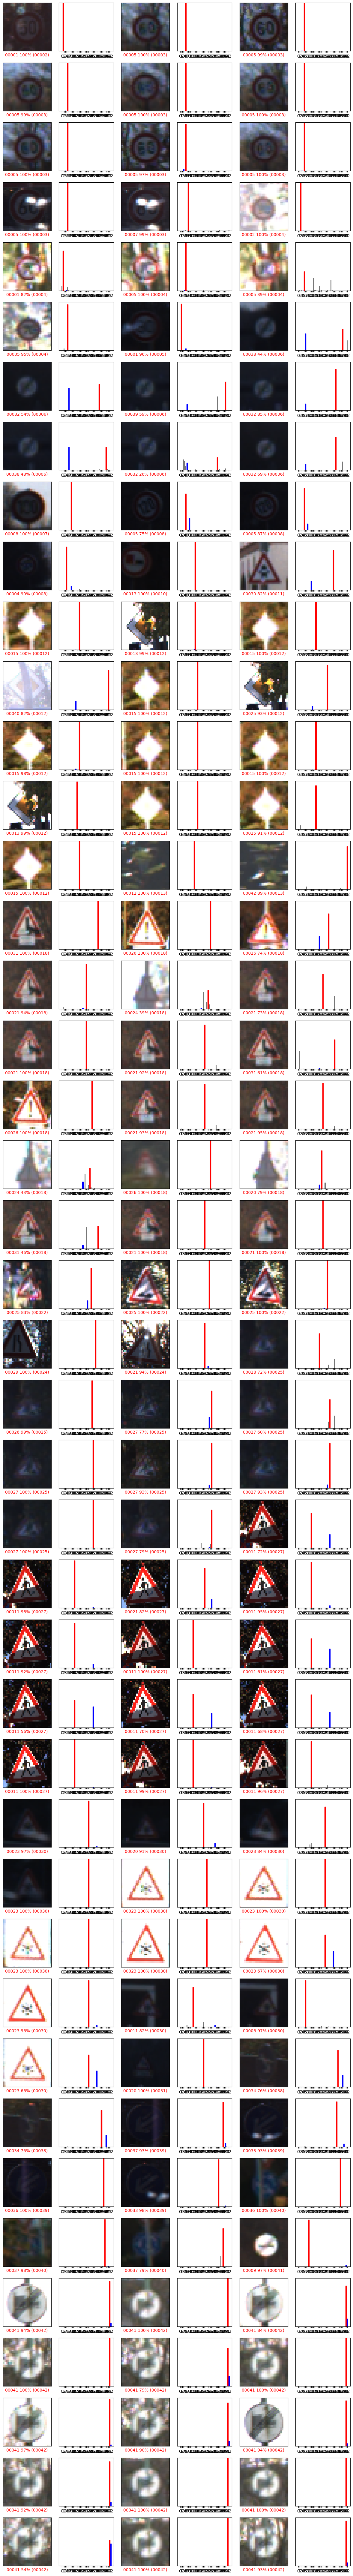

In [19]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in testset.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV31.predict(images.numpy()))


show_misclassified(pred, numpy_labels, numpy_images, int((12630 - 12630*.9898)/3 + 1))

In [ ]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in testset.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV2.predict(images.numpy()))


show_misclassified(pred, numpy_labels, numpy_images, int((12630 - 12630*.9894)/3 + 1))

## Model 2

In [40]:
dataV32 = trainset


# color ops
dataV32 = dataV32.map(process_image)
aux = dataV32
dataV32 = dataV32.concatenate(aux.map(process_contrast))


#geometry ops
dataV32 = dataV32.concatenate(aux.map(process_shear))
dataV32 = dataV32.concatenate(aux.map(process_crop))
dataV32 = dataV32.concatenate(aux.map(process_squares))
dataV32 = dataV32.concatenate(dataV32.map(process_blur))


dataV32 = dataV32.cache()

dataV3_length = dataset.cardinality().numpy()
dataV32 = dataV32.shuffle(buffer_size = dataV3_length,reshuffle_each_iteration=False)
dataV32 = dataV32.batch(batch_size = BATCH_SIZE)
dataV32 = dataV32.prefetch(buffer_size = AUTOTUNE)

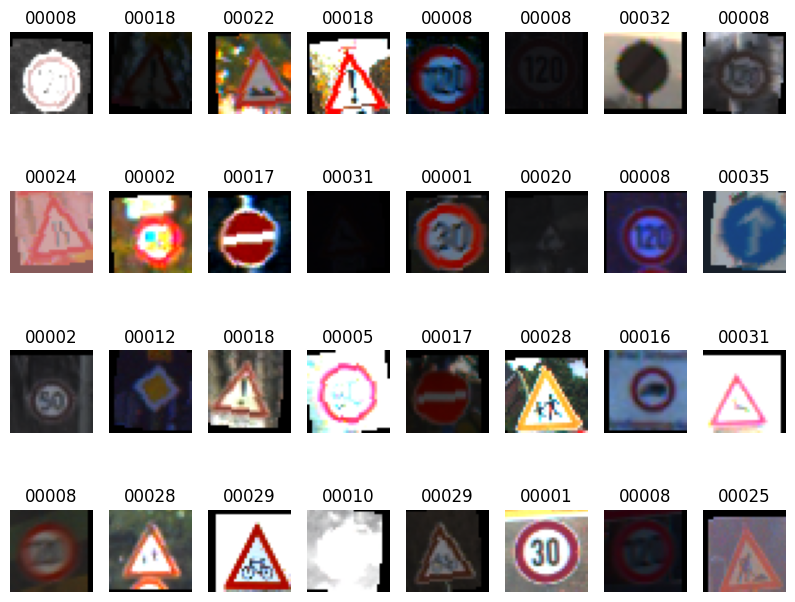

In [41]:
image_batch, label_batch = next(iter(dataV32))
show_batch(image_batch, label_batch.numpy())

train model

In [20]:
modelV32 = model_III(43, IMAGE_SIZE, 3)
file_pathV32 = f'{log_and_model_path}/DA_modelV32/cp.ckpt'

In [ ]:
callbacksV32 = prepare_callbacks(file_pathV32)

historyV32 = modelV32.fit(dataV32,
          epochs = 50,
          validation_data = valset,
          callbacks = callbacksV32)

Evaluate model

In [21]:
modelV32.load_weights(file_pathV32)

evalV32 = modelV32.evaluate(testset, verbose=2)

99/99 - 18s - loss: 0.0659 - accuracy: 0.9917 - 18s/epoch - 181ms/step


show missclassified

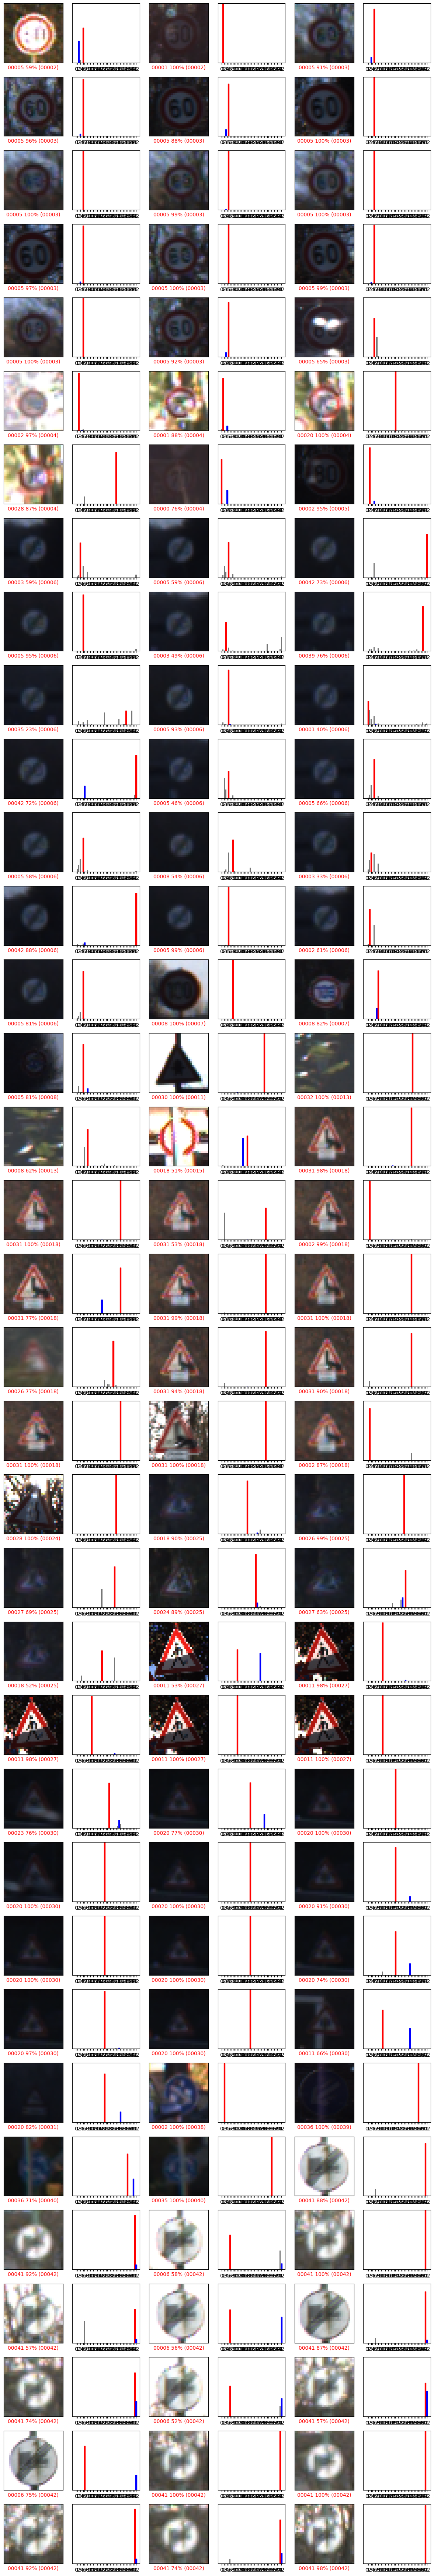

In [23]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in testset.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV32.predict(images.numpy()))


show_misclassified(pred, numpy_labels, numpy_images, int((12630 - 12630*.9917)/3 + 1))

## Model 3

In [46]:
dataV33 = trainset


dataV33 = dataV33.map(process_image)
# color ops
dataV33 = dataV33.concatenate(trainset.map(process_contrast))

#geometry ops
dataV33 = dataV33.concatenate(trainset.map(process_shear))
dataV33 = dataV33.concatenate(trainset.map(process_crop))
dataV33 = dataV33.concatenate(trainset.map(process_squares))
dataV33 = dataV33.concatenate(trainset.map(process_hlines))
dataV33 = dataV33.concatenate(trainset.map(process_vlines))
dataV33 = dataV33.concatenate(dataV33.map(process_blur))


dataV33 = dataV33.cache()

dataV3_length = dataset.cardinality().numpy()
dataV33 = dataV33.shuffle(buffer_size = dataV3_length,reshuffle_each_iteration=False)
dataV33 = dataV33.batch(batch_size = BATCH_SIZE)
dataV33 = dataV33.prefetch(buffer_size = AUTOTUNE)

show batch of images

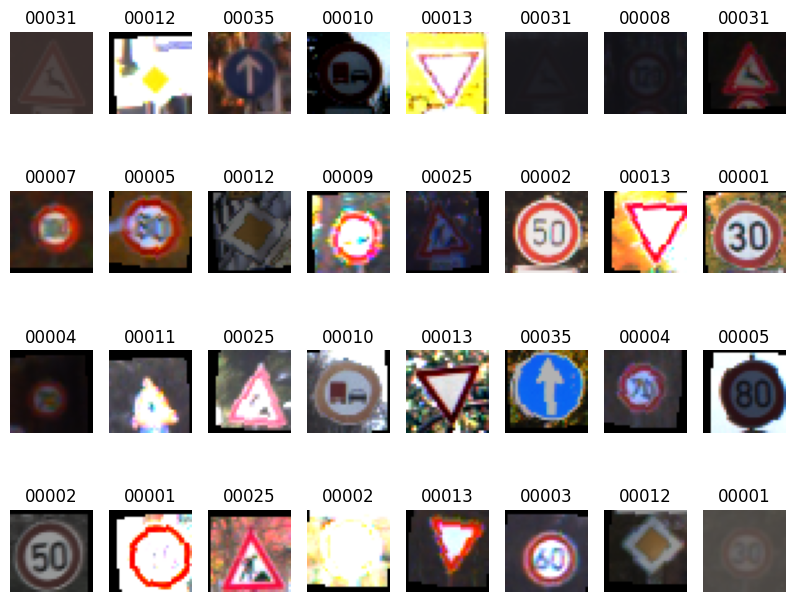

In [49]:
image_batch, label_batch = next(iter(dataV33))
show_batch(image_batch, label_batch.numpy())

train model

In [27]:
modelV33 = model_III(43, IMAGE_SIZE, 3)
#Best model is saved in f'{log_and_model_path}/DA_modelV33/cp.ckpt' with 9941 accuracy
file_pathV33 = f'{log_and_model_path}/DA_modelV33/cp.ckpt'

In [ ]:
callbacksV33 = prepare_callbacks(file_pathV33)

historyV3 = modelV33.fit(dataV33,
          epochs = 50,
          validation_data = valset,
          callbacks = callbacksV33)

Evaluate Model

In [28]:
modelV33.load_weights(file_pathV33)

evalV33 = modelV33.evaluate(testset, verbose=2)

99/99 - 3s - loss: 0.0222 - accuracy: 0.9941 - 3s/epoch - 31ms/step


Show missclassified

3/3 [==============================] - 0s 8ms/step
75


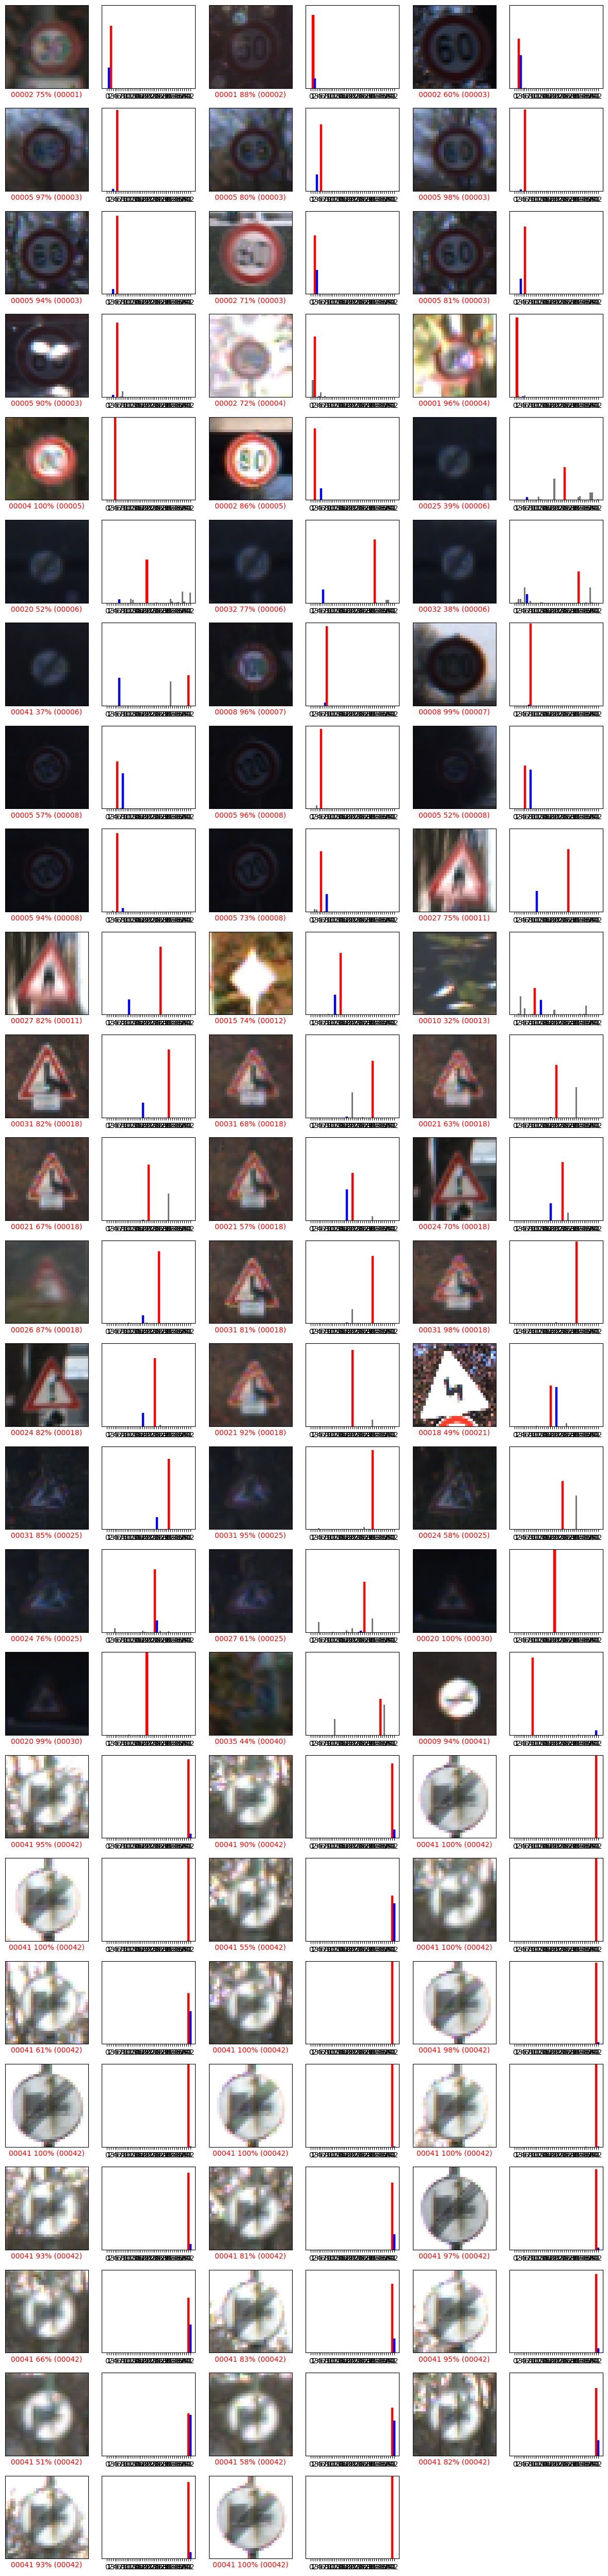

In [ ]:
numpy_labels = []
numpy_images = []
pred = []

for images, labels in testset.take(-1):  # take all batches of dataset
    numpy_images.extend(images.numpy())
    numpy_labels.extend(labels.numpy())
    pred.extend(modelV3.predict(images.numpy()))


show_misclassified(pred, numpy_labels, numpy_images, int((12630 - 12630*.9941)/3 + 1))

## IV Ensemble the models

In [30]:
# concatenate the models

# import concatenate layer
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Input

# get list of models
models = [ modelV31, modelV32, modelV33]

input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='input') # input layer

# get output for each model input
outputs = [model(input) for model in models]

# contenate the ouputs
x = Concatenate()(outputs)

# add further layers
x = Dropout(0.5)(x)
output = Dense(43, activation='softmax', name='output')(x) # output layer

# create concatenated model
conc_model = tf.keras.Model(input, output, name= 'Concatenated_Model')

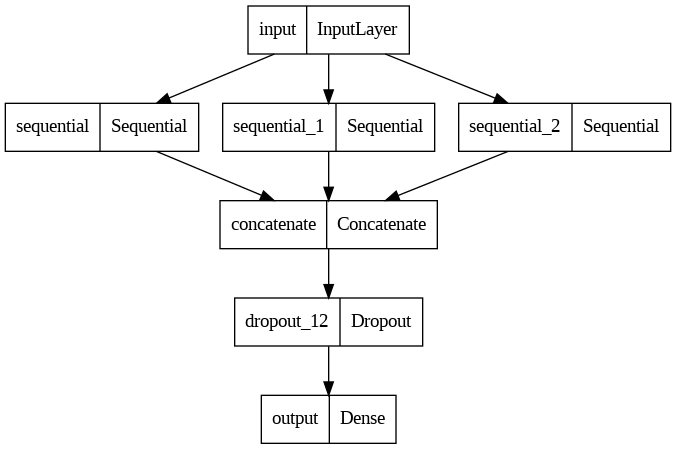

In [31]:
# show model structure
from tensorflow.keras.utils import plot_model
plot_model(conc_model)

## transform dataset

augmentation process

In [50]:
import random


def process_image_conc(image, label):

    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    image = tfa.image.translate(image, [rx, ry])

    # change hue, saturation and value
    image = tfa.image.random_hsv_in_yiq(image, 0.2, 0.1, 3, 0.1, 3)
    image = tf.clip_by_value(image,0,1)

    # random contrast
    image = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)

    #decide wich transformation to perform
    random_tranform = random.randint(1, 4)
    if random_tranform == 1:
      image, _ = process_squares(image, label)

    elif random_tranform == 2:
      image, _ = process_hlines(image,label)

    elif random_tranform == 3:
      image, _ = process_vlines(image,label)

    return image, label

In [51]:
data_conc = trainset

data_conc = data_conc.map(process_image_conc)

#geometry ops
data_conc = data_conc.concatenate(trainset.map(process_shear))
data_conc = data_conc.concatenate(trainset.map(process_crop))
data_conc = data_conc.concatenate(data_conc.map(process_blur))


data_conc = data_conc.cache()

data_length = data_conc.cardinality().numpy()
data_conc = data_conc.shuffle(buffer_size = data_length,reshuffle_each_iteration=False)
data_conc = data_conc.batch(batch_size = BATCH_SIZE)
data_conc = data_conc.prefetch(buffer_size = AUTOTUNE)

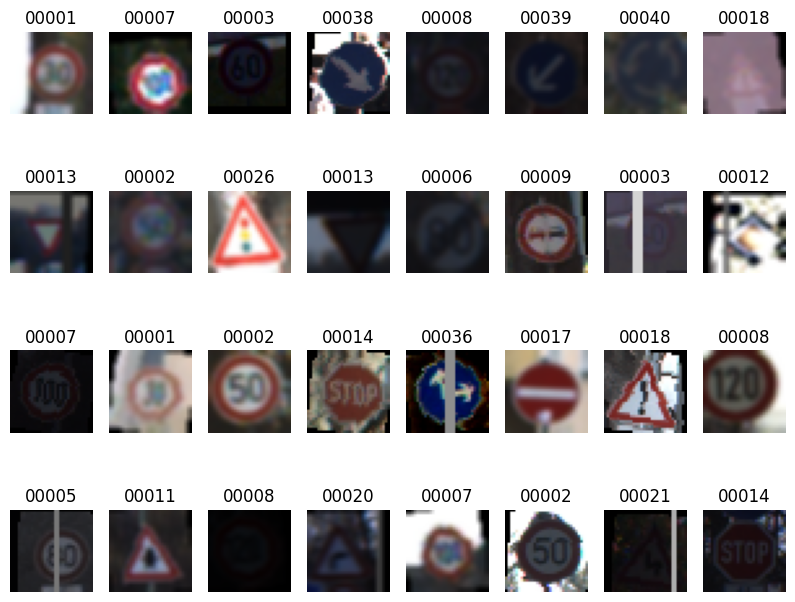

In [52]:
image_batch, label_batch = next(iter(data_conc))
show_batch(image_batch, label_batch.numpy())

train concatenated model

In [40]:
file_path_conc = f'{log_and_model_path}/DA_model_conc/cp.ckpt'
opt = Adam(lr=0.0001)
conc_model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])

In [41]:
callbacks_conc = prepare_callbacks(file_path_conc)

history_conc = conc_model.fit(data_conc,
          epochs = 50,
          validation_data = valset,
          callbacks = callbacks_conc)

Epoch 1/50
   6/5882 [..............................] - ETA: 8:07 - loss: 3.7748 - accuracy: 0.0365

5882/5882 [==============================] - ETA: 0s - loss: 1.1930 - accuracy: 0.8046
Epoch 1: val_accuracy improved from -inf to 0.99962, saving model to /content/drive/MyDrive/VCPI/cache//DA_model_conc/cp.ckpt
5882/5882 [==============================] - 601s 77ms/step - loss: 1.1930 - accuracy: 0.8046 - val_loss: 0.0439 - val_accuracy: 0.9996 - lr: 0.0010
Epoch 2/50
5882/5882 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.8292
Epoch 2: val_accuracy improved from 0.99962 to 1.00000, saving model to /content/drive/MyDrive/VCPI/cache//DA_model_conc/cp.ckpt

Reached target validation accuracy (1.0), stopping training!
5882/5882 [==============================] - 439s 75ms/step - loss: 0.7036 - accuracy: 0.8292 - val_loss: 0.0103 - val_accuracy: 1.0000 - lr: 0.0010


evaluate

In [42]:
conc_model.load_weights(file_path_conc)

eval_conc = conc_model.evaluate(testset, verbose=2)

99/99 - 5s - loss: 0.0457 - accuracy: 0.9909 - 5s/epoch - 54ms/step
